[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab5_generalization.ipynb)

# Lab 5: Measuring Performance

## Objectives


*   Understand how to accurately measure generalization performance of deep networks
*   Gain intuition into the bias-variance trade-off and the double descent phenomenon
*   Investigate properties of high dimensional spaces and better understand the ''curse of dimensionality''



## Deliverable

You will turn in a completed version of notebook to Canvas/Learning Suite.  In various places you will see the words "TO DO". Follow the instructions at these places and write code to complete the instructions



## Notes
You will not need a GPU instance for this lab

## Q1) Understanding Generalization

In this question, we will use the MNIST1D dataset (https://github.com/greydanus/mnist1d) to reproduce Figure 8.2 from Prince.

In [90]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-y7t5pyem
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-y7t5pyem
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [91]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code. The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [92]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print(data['x'])
print(data['y'])
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Successfully loaded data from ./sample_data/mnist1d_data.pkl
[[-0.33200567 -0.47191037 -0.77869708 ... -0.7167305  -0.96195825
  -0.89016639]
 [ 1.96548088  2.30021254  2.21339278 ... -1.68751297 -1.42642212
  -1.36421511]
 [-0.01930303  0.07863308  0.62488909 ... -1.08555748 -1.79809121
  -2.3153282 ]
 ...
 [-1.69449348 -1.2805858  -0.65125255 ... -0.72365942 -0.38266551
  -0.03165042]
 [ 0.99646721  0.80844603  0.1553411  ... -0.30286571 -0.28555128
  -0.1183879 ]
 [-0.6939948  -0.27532169  0.29267968 ... -1.21624513 -1.4649417
  -1.65099286]]
[2 6 4 ... 5 4 8]
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [93]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

### Part 1.a)

**TODO:** Define a PyTorch model with two hidden layers of size 100 And ReLU activations between them

In [94]:
# Your code here (see Figure 7.8 of book for help)
def model_definition():
  model = nn.Sequential(
      nn.Linear(D_i, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_o)
  )
  return model

model = model_definition()

**TODO:** Initialize the parameters with He initialization

In [95]:
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
      nn.init.kaiming_normal_(layer_in.weight)
      layer_in.bias.data.fill_(0.0)

In [96]:
# Call the function you just defined
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [97]:
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [98]:
def train_model(model, data_loader, n_epoch=50):

    # Initialize model weights
    model.apply(weights_init)

    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))

    # choose cross entropy loss function (equation 5.24)
    loss_function = torch.nn.CrossEntropyLoss()
    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
    # object that decreases learning rate by half every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


    for epoch in range(n_epoch):
      # loop over batches
      for i, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch)
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

      # Run whole dataset to get statistics -- normally wouldn't do this
      pred_train = model(x_train)
      pred_test = model(x_test)
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_test_class = torch.max(pred_test.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
      losses_train[epoch] = loss_function(pred_train, y_train).item()
      losses_test[epoch]= loss_function(pred_test, y_test).item()
      print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

      # tell scheduler to consider updating learning rate
      scheduler.step()

    return errors_train, errors_test, losses_train, losses_test

In [99]:
def plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50):

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(errors_train,'r-',label='train')
    ax.plot(errors_test,'b-',label='test')
    ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
    ax.legend()
    plt.show()

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(losses_train,'r-',label='train')
    ax.plot(losses_test,'b-',label='test')
    ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
    ax.legend()
    plt.show()

**TODO:** Train your model for 50 epochs

In [100]:
# Your code here
errors_train, errors_test, losses_train, losses_test = train_model(model, data_loader, n_epoch=50)

Epoch     0, train loss 1.601749, train error 65.10,  test loss 1.685076, test error 68.40
Epoch     1, train loss 1.317112, train error 48.85,  test loss 1.452639, test error 58.90
Epoch     2, train loss 1.148818, train error 42.20,  test loss 1.350213, test error 53.80
Epoch     3, train loss 1.003173, train error 36.35,  test loss 1.270774, test error 51.70
Epoch     4, train loss 0.917191, train error 32.65,  test loss 1.183315, test error 47.40
Epoch     5, train loss 0.826863, train error 29.90,  test loss 1.187877, test error 45.90
Epoch     6, train loss 0.702421, train error 24.03,  test loss 1.104395, test error 43.30
Epoch     7, train loss 0.634450, train error 22.47,  test loss 1.109736, test error 42.10
Epoch     8, train loss 0.605118, train error 21.75,  test loss 1.116843, test error 41.90
Epoch     9, train loss 0.507043, train error 17.15,  test loss 1.080876, test error 39.30
Epoch    10, train loss 0.422257, train error 12.65,  test loss 1.009421, test error 38.00

**TODO**: Plot the resulting quantities:
- Train errors
- Test errors
- Train losses
- Test losses

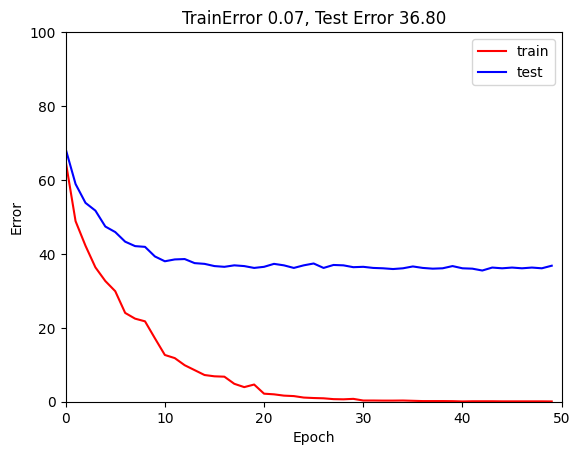

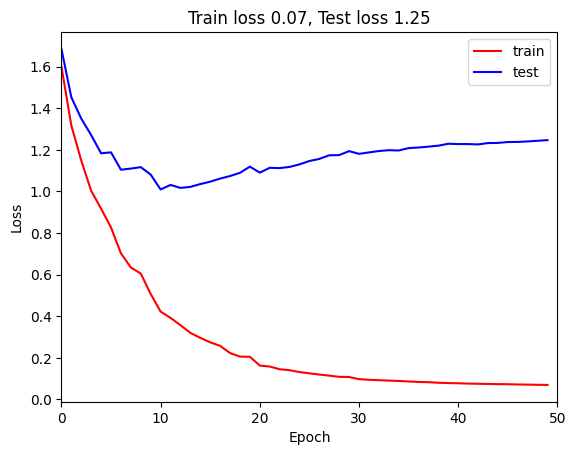

In [101]:
# Your code here
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.b)

Now let's increase the capacity of our model to have five hidden layers and re-run our experiment. Pay attention to what happens to the train and test curves.

**TODO:**
Define a model with five hidden layers of size 100
and ReLU activations between them

In [102]:
# Your code here:
def model_definition():
  model = nn.Sequential(
      nn.Linear(D_i, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_o),
  )
  return model

model = model_definition()

**TODO**: Train the model using the same code as above

In [103]:
# Your code here
errors_train, errors_test, losses_train, losses_test = train_model(model, data_loader, n_epoch=50)

Epoch     0, train loss 1.662583, train error 67.03,  test loss 1.731474, test error 70.50
Epoch     1, train loss 1.469640, train error 59.35,  test loss 1.566033, test error 64.30
Epoch     2, train loss 1.215605, train error 47.00,  test loss 1.400970, test error 54.50
Epoch     3, train loss 1.226243, train error 48.08,  test loss 1.448012, test error 56.60
Epoch     4, train loss 0.930454, train error 36.10,  test loss 1.221692, test error 48.10
Epoch     5, train loss 0.903361, train error 34.95,  test loss 1.242807, test error 47.90
Epoch     6, train loss 0.708794, train error 27.07,  test loss 1.135330, test error 40.70
Epoch     7, train loss 0.696732, train error 26.45,  test loss 1.219240, test error 44.20
Epoch     8, train loss 0.602027, train error 22.93,  test loss 1.131897, test error 41.70
Epoch     9, train loss 0.599761, train error 22.60,  test loss 1.224750, test error 41.00
Epoch    10, train loss 0.271167, train error 9.05,  test loss 1.131580, test error 35.90


**TODO**: Plot the results using the same code as above

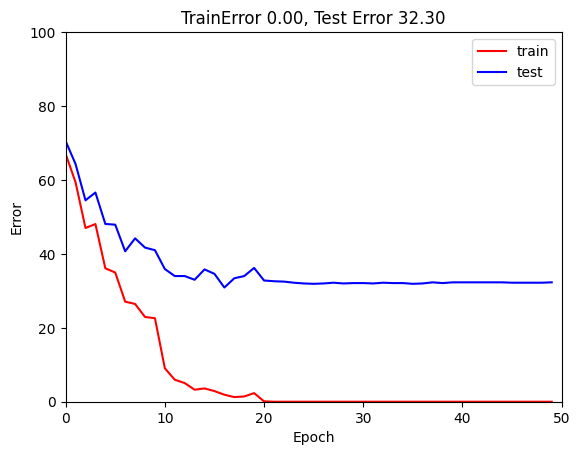

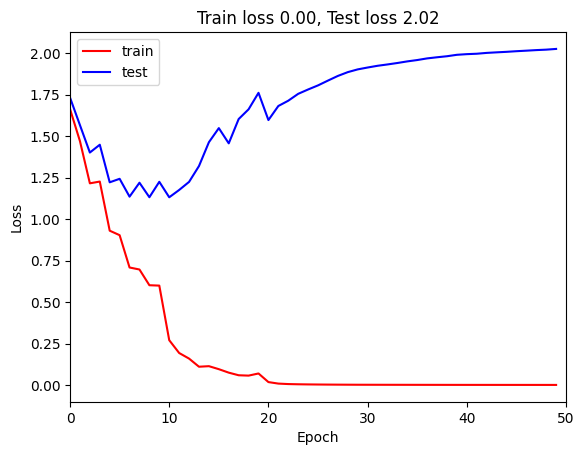

In [104]:
# Your code here
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.c)

Let's run one last experiment, this time with a simple linear model with **NO** hidden layers. In this case we will decrease the capacity of the model. Again, pay attention to what happens to the train and test curves.

**TODO:** Define a model with no hidden layers. This model should just be a linear layer that maps from the input dimension, `D_i` to the output dimension, `D_o`

In [105]:
# Your code here
def model_definition():
  model = nn.Sequential(
      nn.Linear(D_i, D_o)
  )
  return model

model = model_definition()

**TODO**: Train the model using the same code as above


In [106]:
# Your code here
errors_train, errors_test, losses_train, losses_test = train_model(model, data_loader, n_epoch=50)

Epoch     0, train loss 1.772058, train error 70.20,  test loss 1.796277, test error 73.50
Epoch     1, train loss 1.692675, train error 68.28,  test loss 1.711100, test error 71.10
Epoch     2, train loss 1.665664, train error 66.25,  test loss 1.718373, test error 71.40
Epoch     3, train loss 1.653934, train error 66.68,  test loss 1.683543, test error 69.70
Epoch     4, train loss 1.643554, train error 66.30,  test loss 1.693336, test error 69.60
Epoch     5, train loss 1.633133, train error 65.55,  test loss 1.676404, test error 68.50
Epoch     6, train loss 1.624885, train error 65.12,  test loss 1.674622, test error 68.80
Epoch     7, train loss 1.623023, train error 65.30,  test loss 1.665411, test error 68.20
Epoch     8, train loss 1.617706, train error 63.78,  test loss 1.662103, test error 68.40
Epoch     9, train loss 1.619714, train error 64.20,  test loss 1.671632, test error 67.60
Epoch    10, train loss 1.602505, train error 63.60,  test loss 1.654388, test error 67.90

**TODO**: Plot the results using the same code as above

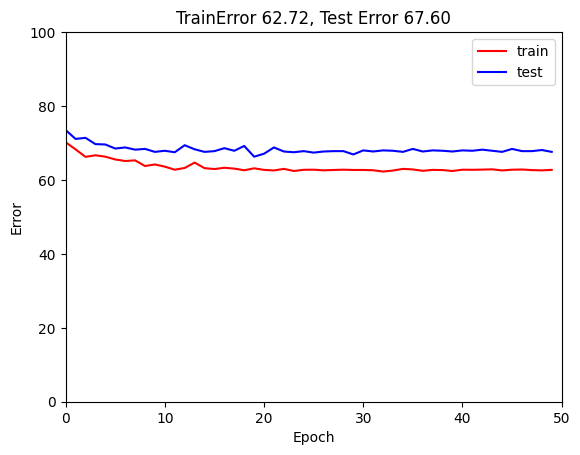

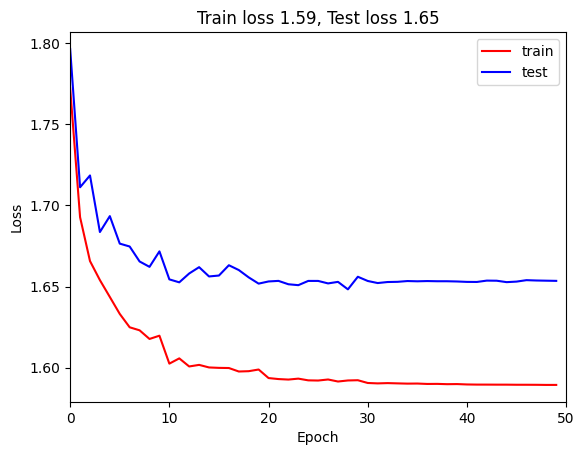

In [107]:
# Your code here
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.d: Discussion
What did you observe as you changed the model capacity in your experiments? What are some measures you might include to improve generalization of your models?

What I noticed is that when we ran the 5-hidden layer model,as compared, with the 2-hidden layer model had a perfect validation acc, but the test error was atrocias in comparison with around 36% error. This tells me that our model is memeorizing the training data and that we have overfit. Also I noticed that when we didn't have any hidden layers caused the model to underfit and not learn. This is a high bias for this case.



## Q2:  Bias-variance Trade-off

In this problem, we will investigate the bias-variance trade-off and reproduce the curves seen in Figure 8.8 in Prince.

In [109]:
import numpy as np
import matplotlib.pyplot as plt

Let's specify the true function that we are trying to estimate, defined on [0,1]

In [110]:
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

Now let's generate some data point and add bit of noise to the labels

In [111]:
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y


Let's draw the fitted function, together with uncertainty used to generate points


In [112]:
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, x')
    ax.set_ylabel('Output, y')
    plt.show()
    plt.show()

Sample from the true function (no noise):

In [113]:
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

Generate some training data (with noise):

In [114]:
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

<ipython-input-111-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-111-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


Plot the data with the functions defined above

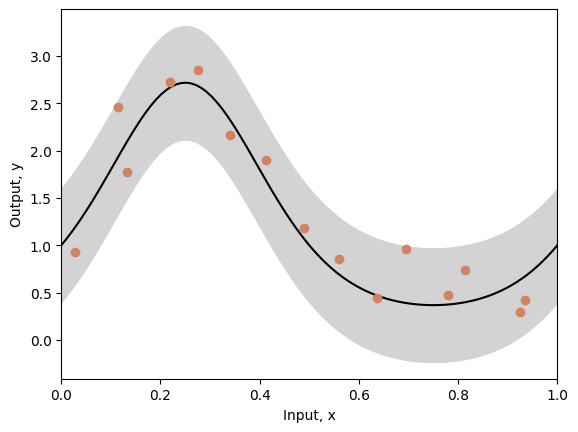

In [115]:
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [116]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [117]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

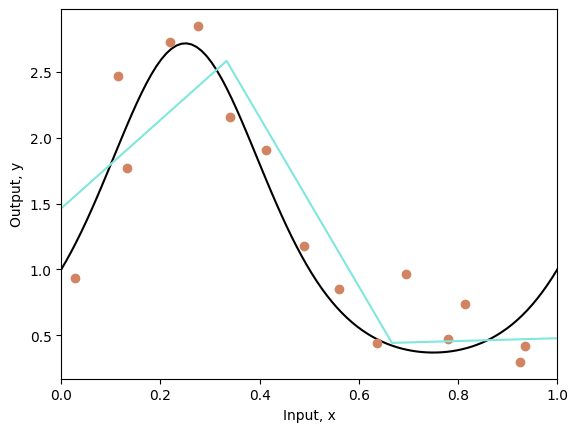

In [118]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

### Part 2.a) Estimating the mean and variance of the model outputs, over many training runs

**TODO:** Fill in the missing pieces of this function to tun the model many times with different datasets and return the mean and variance


In [119]:
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):

  # Create array that stores model results in rows
  y_model_all = np.zeros((n_datasets, n_data))

  for c_dataset in range(n_datasets):
    # TODO -- Generate n_data x,y, pairs with standard deviation sigma_func
    # Replace this line
    x_data, y_data = generate_data(n_data, sigma_func)

    # TODO -- Fit the model
    # Replace this line:
    beta, omega = fit_model_closed_form(x_data,y_data,n_hidden)

    # TODO -- Run the fitted model on x_model
    # Replace this line
    x_model = np.linspace(0,1,n_data)
    y_model = network(x_model, beta, omega)

    # Store the model results
    y_model_all[c_dataset,:] = y_model

  # Get mean and standard deviation of model
  mean_model = np.mean(y_model_all,axis=0)
  std_model = np.std(y_model_all,axis=0)

  # Return the mean and standard deviation of the fitted model
  return mean_model, std_model

Let's generate N=100 random data sets, fit the model N=100 times and look the mean and variance. Here we will have 15 data points and 3 hidden units in our model:

In [120]:
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 3

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

<ipython-input-111-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-111-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


Plot the results


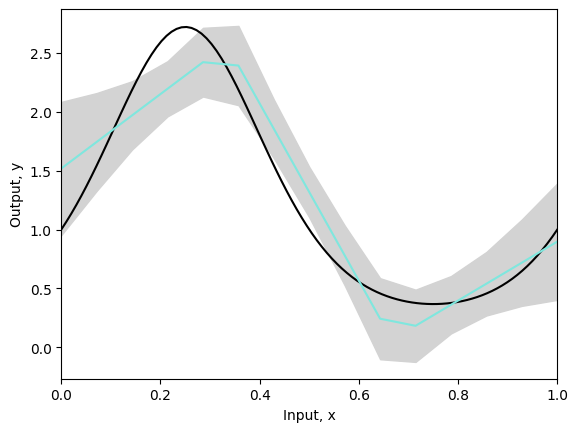

In [121]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

If you did this correctly, you can see that there that we observe both **bias** and **variance** in the model outputs. Here bias refers to the fact that we have some error from the model outputs and the true function (distance between cyan and black lines); variance refers to the gray region indicating there is a fair amount of variability in what the model outputs over each dataset it sees.


### Part 2.b) Changing the amount of available data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase the the number of training points to 100, `n_data=100`

In [122]:
n_datasets = 100
n_data = 100
sigma_func = 0.3
n_hidden = 3

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

<ipython-input-111-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-111-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


**TODO**: Plot the results:

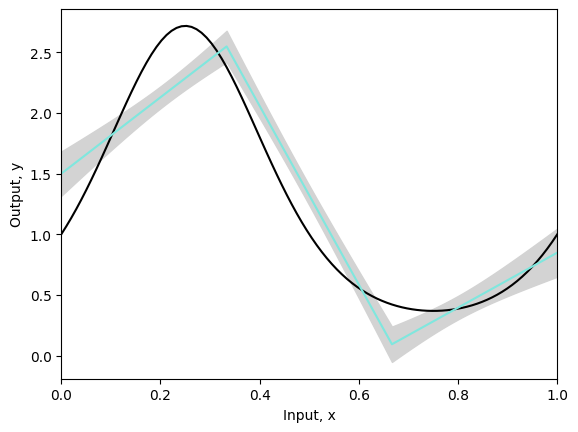

In [123]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: What happened to the variance? Record your observations

When we increase the number of training steps, the variance is high causing our model to overfit.

### Part 2.c) Increasing the model capacity

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 15

In [124]:
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 12

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

<ipython-input-111-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-111-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


**TODO**: Plot the results

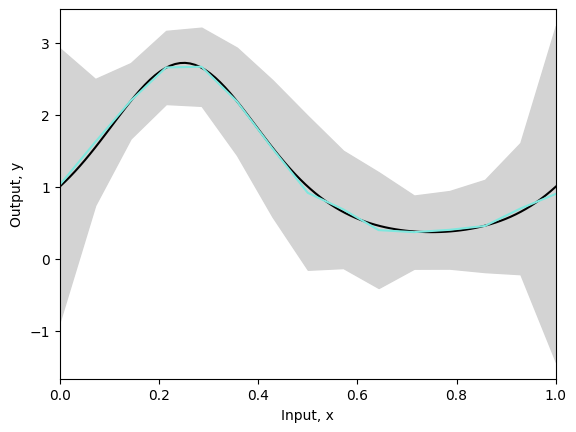

In [125]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: What happened to the bias? Record your observations

The bias isn't very high and not super low since the model is stil able to learn very well without extreme noise.

### Part 2.d) High capacity and high data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 1000

In [126]:
n_datasets = 100
n_data = 1000
sigma_func = 0.3
n_hidden = 12

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

<ipython-input-111-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-111-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


**TODO:** Plot the results

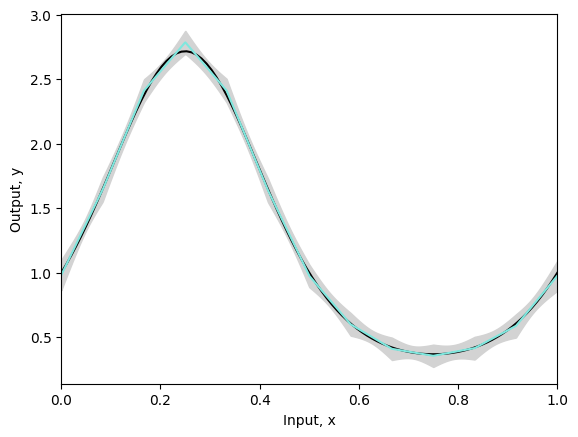

In [127]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: Record your observations about the bias and variance in this setting

In this case, the bias and vairance are low which is what we want for our model to output.

## Q3) High Dimensional Spaces
This question investigates the strange properties of high-dimensional spaces as discussed in the notes at the end of chapter 8.



In [128]:
from scipy.spatial.distance import pdist

In [129]:
# Fix the random seed so we all have the same random numbers
np.random.seed(0)
n_data = 1000
# Create 1000 data examples (columns) each with 2 dimensions (rows)
n_dim = 2
x_2D = np.random.normal(size=(n_dim,n_data))
# Create 1000 data examples (columns) each with 100 dimensions (rows)
n_dim = 100
x_100D = np.random.normal(size=(n_dim,n_data))
# Create 1000 data examples (columns) each with 1000 dimensions (rows)
n_dim = 1000
x_1000D = np.random.normal(size=(n_dim,n_data))


**TODO:** Implement the missing parts of the function below:

In [130]:
def distance_ratio(x):
  # TODO -- replace the two lines below to calculate the largest and smallest Euclidean distance between
  # the data points in the columns of x.  DO NOT include the distance between the data point
  # and itself (which is obviously zero)
  distances = pdist(x, metric='euclidean')

  # Find the smallest and largest distance
  smallest_dist = np.min(distances)
  largest_dist = np.max(distances)

  # Calculate the ratio and return
  dist_ratio = largest_dist / smallest_dist
  return dist_ratio

In [131]:

print('Ratio of largest to smallest distance 2D: %3.3f'%(distance_ratio(x_2D)))
print('Ratio of largest to smallest distance 100D: %3.3f'%(distance_ratio(x_100D)))
print('Ratio of largest to smallest distance 1000D: %3.3f'%(distance_ratio(x_1000D)))


Ratio of largest to smallest distance 2D: 1.000
Ratio of largest to smallest distance 100D: 1.184
Ratio of largest to smallest distance 1000D: 1.228


If you did this right, you will see that the distance between the nearest and farthest two points in high dimensions is almost the same.

